In [1]:
from google.colab import drive
drive.mount('/content/drive')


%cd '/content/drive/My Drive/tfg/tfg/'

# Mostrar el directorio actual para confirmar el cambio
directorio_actual = %pwd
print("Directorio actual:", directorio_actual)

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/10WLcTPxhJDTxR9pv6DkdJbsqxpkkFOIV/tfg/tfg
Directorio actual: /content/drive/.shortcut-targets-by-id/10WLcTPxhJDTxR9pv6DkdJbsqxpkkFOIV/tfg/tfg


In [2]:
import os
import pandas as pd
path_actual = os.getcwd()
subdirectorio = 'datas'
file_train = 'df_train.csv'
path_train = os.path.join(path_actual, subdirectorio, file_train)

In [3]:
file_valid = 'df_valid.csv'
path_valid = os.path.join(path_actual, subdirectorio, file_valid)

In [4]:
import pandas as pd

df_train = pd.read_csv(path_train, index_col=None)
df_valid = pd.read_csv(path_valid, index_col=None)

In [5]:
import numpy as np
import pandas as pd

def filtrado_datos_variable(df):
    kaones = []
    labels = []

    df_sorted = df.sort_values(by=['eventID', 'hitTime'], ascending=[True, False])

    for eventID, grupo in df_sorted.groupby('eventID'):
        pdgCodes = grupo['PDGcode'].unique()

        for pdgCode in pdgCodes:
            grupo_filtrado = grupo[grupo['PDGcode'] == pdgCode]

            # Extraer directamente los valores
            hitX_values = grupo_filtrado['hitX'].values
            hitY_values = grupo_filtrado['hitY'].values
            hitZ_values = grupo_filtrado['hitZ'].values
            hitInteg_values = grupo_filtrado['hitInteg'].values

            # Concatenar los valores directamente sin padding
            hit_values_reorganized = np.concatenate([hitX_values, hitY_values, hitZ_values, hitInteg_values])

            kaones.append(hit_values_reorganized)

            # Modificar las etiquetas de 211 a 0 y de 321 a 1
            if pdgCode == 211:
                labels.append(0)
            elif pdgCode == 321:
                labels.append(1)

    return kaones, np.array(labels)


In [ ]:
import matplotlib.pyplot as plt
def pintar_metricas(history):
  plt.figure(figsize=(10, 5))
  plt.plot(history['loss'], label='Entrenamiento', color='blue')
  plt.plot(history['val_loss'], label='Validacion', color='orange')
  plt.title('Funcion de perdida en el conjunto de datos de entrenamiento y validacion')
  plt.xlabel('Epocas')
  plt.ylabel('Funcion de perdida')
  plt.legend()
  plt.grid(True)
  min_y=0
  max_y=0.6
  plt.ylim(min_y, max_y)
  plt.yticks(np.arange(min_y, max_y, 0.05))
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(history['accuracy'], label='Entrenamiento', color='blue')
  plt.plot(history['val_accuracy'], label='Validacion', color='orange')
  plt.title('Accuracy en el conjunto de datos de entrenamiento y validacion')
  plt.xlabel('Epocas')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  min_y=0.7
  max_y=1
  plt.ylim(min_y, max_y)
  plt.yticks(np.arange(min_y, max_y, 0.05))
  plt.show()

In [6]:
X_train, y_train = filtrado_datos_variable(df_train)
X_valid, y_valid = filtrado_datos_variable(df_valid)

In [ ]:
tam = np.array([])
for fila in X_train:
  tam = np.append(tam, len(fila))


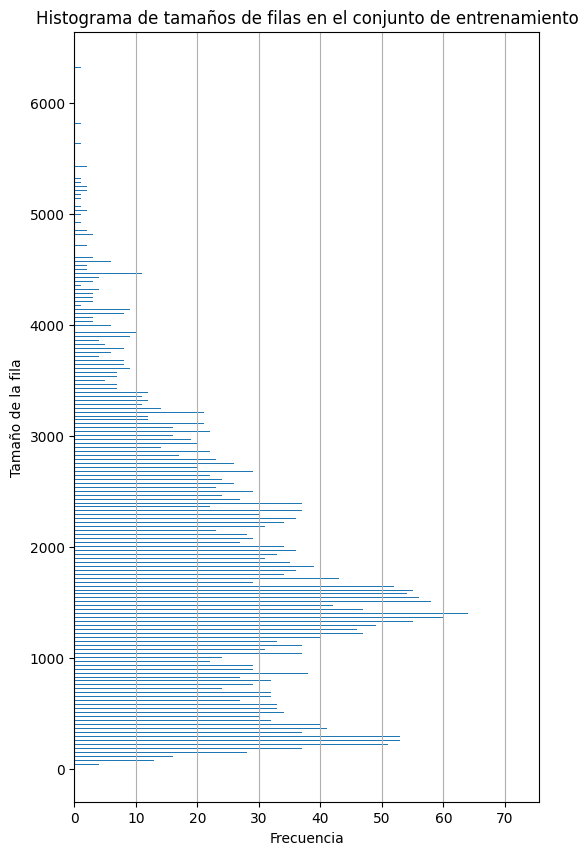

In [ ]:
import matplotlib.pyplot as plt

# Calcular los tamaños de las filas
tam = np.array([len(fila) for fila in X_train])

# Crear el histograma vertical
plt.figure(figsize=(6,10))
plt.hist(tam, bins=range(min(tam), max(tam) + 1), orientation='horizontal')
plt.xlabel('Frecuencia')
plt.ylabel('Tamaño de la fila')
plt.title('Histograma de tamaños de filas en el conjunto de entrenamiento')
plt.grid(axis='x')
plt.show()

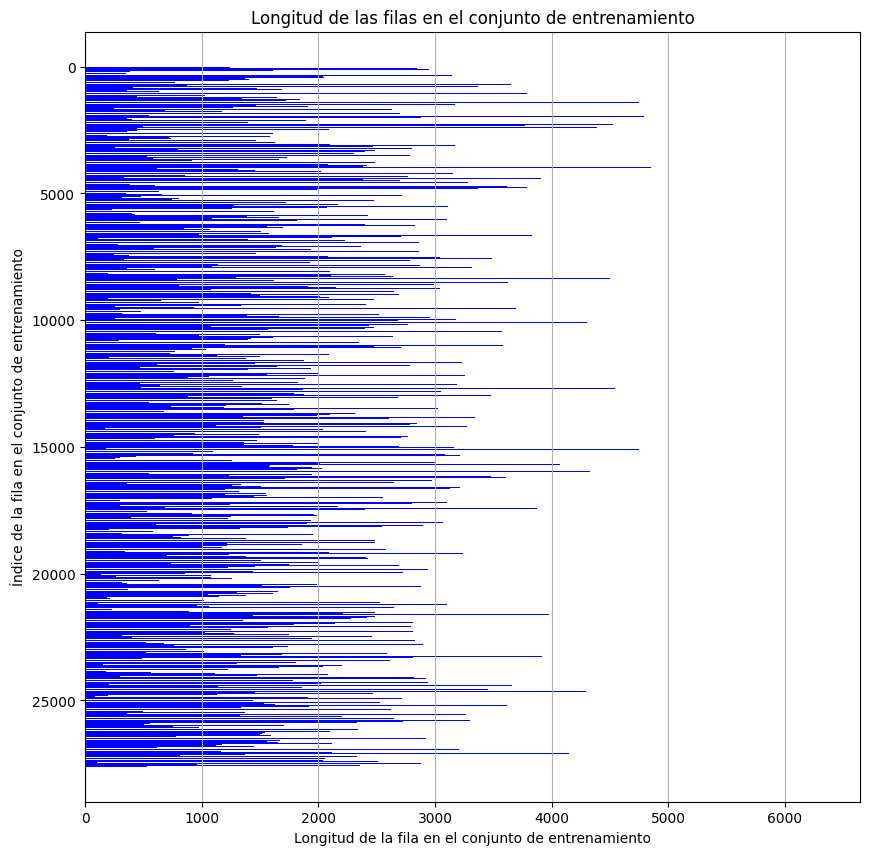

In [ ]:
plt.figure(figsize=(10,10))
plt.barh(range(len(tam)), tam, color='b')
plt.ylabel('Índice de la fila en el conjunto de entrenamiento')
plt.xlabel('Longitud de la fila en el conjunto de entrenamiento')
plt.title('Longitud de las filas en el conjunto de entrenamiento')
plt.gca().invert_yaxis()  # Invertir el eje y para que las filas aparezcan en el orden correcto
plt.grid(axis='x')
plt.show()

In [7]:
from keras.preprocessing.sequence import pad_sequences

max_length = max(len(seq) for seq in X_train)
print('Mayor numero de hits:', max_length)
X_train_p = pad_sequences(X_train, maxlen=max_length, padding='post', dtype='float32')
X_train_p = np.expand_dims(X_train_p, -1)



Mayor numero de hits: 6328


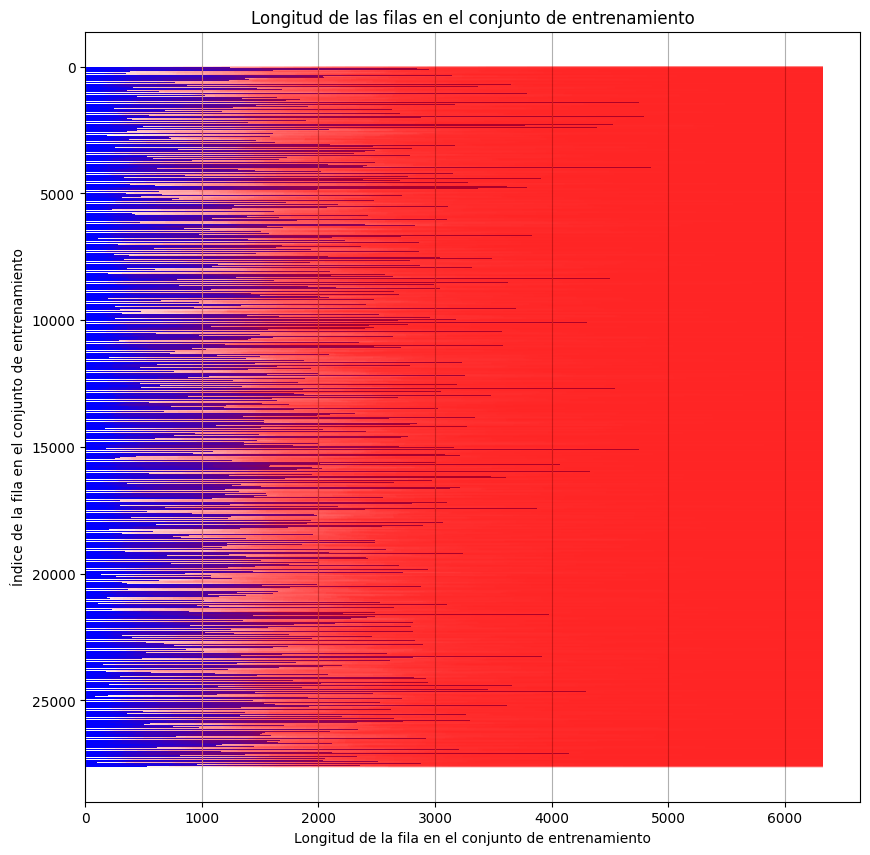

In [ ]:
import matplotlib.pyplot as plt

# Suponiendo que 'tam' contiene las longitudes de cada fila en tu dataset de entrenamiento
tam = [length for length in tam]  # Asumiendo que ya tienes esta lista disponible

plt.figure(figsize=(10,10))
indices = range(len(tam))

# Primero, dibuja las líneas rojas que representan el máximo
plt.hlines(y=indices, xmin=tam, xmax=6328, color='red', alpha=0.5, linewidth=0.05)

# Luego, dibuja las barras azules sobre las líneas rojas
plt.barh(indices, tam, color='blue', edgecolor='none')

plt.ylabel('Índice de la fila en el conjunto de entrenamiento')
plt.xlabel('Longitud de la fila en el conjunto de entrenamiento')
plt.title('Longitud de las filas en el conjunto de entrenamiento')
plt.gca().invert_yaxis()  # Invertir el eje y para que las filas aparezcan en el orden correcto
plt.grid(axis='x')
plt.show()


In [ ]:
### Calcular el porcentaje de padding

total_elementos = np.prod(X_train_p.shape)

non_padding_elementos = sum(len(seq) for seq in X_train)

padding_elementos = total_elementos - non_padding_elementos

padding_porcentaje = (padding_elementos / total_elementos) * 100

print(f"El porcentaje de padding es: {padding_porcentaje:.2f}%")




El porcentaje de padding es: 73.42%


In [8]:
X_valid_p = pad_sequences(X_valid, maxlen=max_length, padding='post', dtype='float32')
X_valid_p = np.expand_dims(X_valid_p, -1)


In [ ]:
X_train_p.shape[1:]

(6328, 1)

In [ ]:
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Conv1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout
from keras.regularizers import l1_l2
from keras.optimizers import Adam
from tensorflow.keras.layers import Masking
tf.random.set_seed(42)

# Funcion para crear el modelo
def create_model_CNN(input_shape):
    model = Sequential()

    # Capa de máscara para ignorar los valores de padding
    # model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # Se eliminan las especificaciones de input_shape para permitir cualquier longitud de entrada
    model.add(Conv1D(filters=128, kernel_size=10, padding='valid', activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=8, padding='valid', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Asumiendo que X_train y X_valid ya están disponibles como listas de arrays de numpy con dimensiones (samples, features)
# No es necesario reorganizar los datos ya que no especificamos una longitud fija

# Creamos el modelo
model_CNN = create_model_CNN(input_shape=X_train_p.shape[1:])

# Definimos callbacks para los entrenamientos
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0, min_lr=0.00001)

# Entrenamos el modelo
history_CNN = model_CNN.fit(X_train_p, y_train, epochs=50, batch_size=32, validation_data=(X_valid_p, y_valid), callbacks=[early_stop, reduce_lr])

# Evaluamos el modelo
loss, accuracy = model_CNN.evaluate(X_valid_p, y_valid)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/50
863/863 [==============================] - 87s 90ms/step - loss: 0.5089 - accuracy: 0.7722 - val_loss: 0.4341 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 2/50
863/863 [==============================] - 78s 90ms/step - loss: 0.4209 - accuracy: 0.7987 - val_loss: 0.3873 - val_accuracy: 0.8289 - lr: 0.0010
Epoch 3/50
863/863 [==============================] - 79s 92ms/step - loss: 0.3666 - accuracy: 0.8374 - val_loss: 0.3330 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 4/50
863/863 [==============================] - 76s 87ms/step - loss: 0.3246 - accuracy: 0.8654 - val_loss: 0.3135 - val_accuracy: 0.8730 - lr: 0.0010
Epoch 5/50
729/863 [========================>.....] - ETA: 10s - loss: 0.3004 - accuracy: 0.8799

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

history =history_CNN.history

plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Entrenamiento', color='blue')
plt.plot(history['val_loss'], label='Validacion', color='orange')
plt.title('Funcion de perdida en el conjunto de datos de entrenamiento y validacion')
plt.xlabel('Epocas')
plt.ylabel('Funcion de perdida')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Entrenamiento', color='blue')
plt.plot(history['val_accuracy'], label='Validacion', color='orange')
plt.title('Accuracy en el conjunto de datos de entrenamiento y validacion')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y=0.7
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

In [ ]:
print(history['loss'])
print(history['val_loss'])
print(history['val_accuracy'])
print(history['accuracy'])


In [ ]:
del model_CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Masking, LSTM, Dense, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
tf.random.set_seed(42)

def create_model_LSTM(input_shape):
    model = Sequential()

    # Capa de máscara para ignorar los valores de padding
    # model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # Capa LSTM
    model.add(LSTM(128, return_sequences=True))

    # Global Average Pooling
    model.add(GlobalAveragePooling1D())

    # Capas densas
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Creamos el modelo
model_LSTM = create_model_LSTM(input_shape=X_train_p.shape[1:])


early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0, min_lr=0.00001)

# Entrenamos el modelo
history_LSTM = model_LSTM.fit(X_train_p, y_train, epochs=50, batch_size=32, validation_data=(X_valid_p, y_valid), callbacks=[early_stop, reduce_lr])

# Evaluamos el modelo
loss, accuracy = model_LSTM.evaluate(X_valid_p, y_valid)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/50
863/863 [==============================] - 184s 204ms/step - loss: 0.3431 - accuracy: 0.8664 - val_loss: 0.2965 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 2/50
863/863 [==============================] - 175s 202ms/step - loss: 0.3010 - accuracy: 0.8878 - val_loss: 0.2842 - val_accuracy: 0.8927 - lr: 0.0010
Epoch 3/50
863/863 [==============================] - 174s 202ms/step - loss: 0.2731 - accuracy: 0.8974 - val_loss: 0.2490 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 4/50
863/863 [==============================] - 175s 203ms/step - loss: 0.2449 - accuracy: 0.9071 - val_loss: 0.2424 - val_accuracy: 0.9132 - lr: 0.0010
Epoch 5/50
863/863 [==============================] - 176s 204ms/step - loss: 0.2282 - accuracy: 0.9178 - val_loss: 0.2177 - val_accuracy: 0.9221 - lr: 0.0010
Epoch 6/50
863/863 [==============================] - 175s 202ms/step - loss: 0.2078 - accuracy: 0.9241 - val_loss: 0.2671 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 7/50
863/863 [==========================

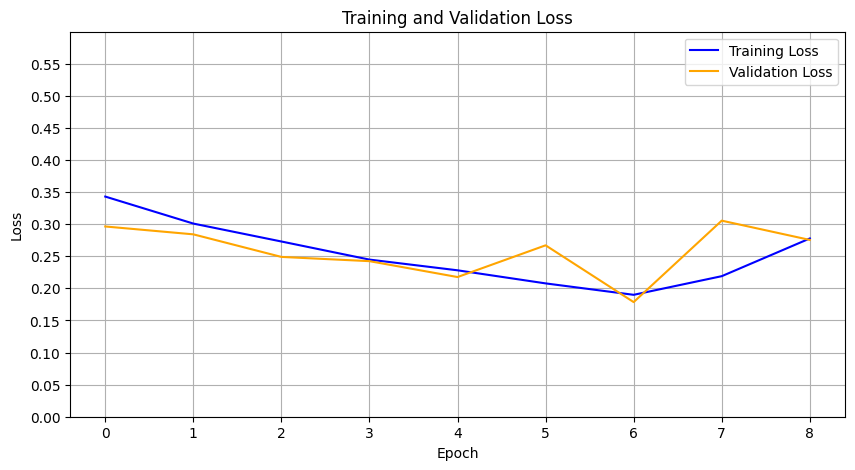

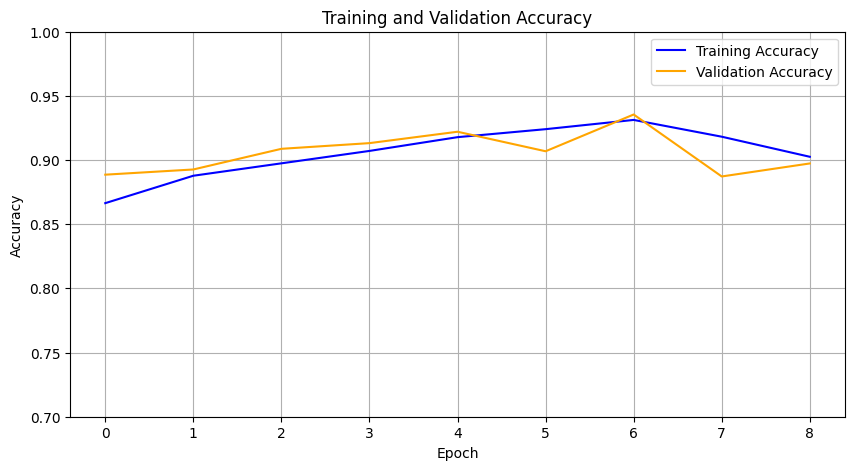

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

history =history_LSTM.history

plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Entrenamiento', color='blue')
plt.plot(history['val_loss'], label='Validacion', color='orange')
plt.title('Funcion de perdida en el conjunto de datos de entrenamiento y validacion')
plt.xlabel('Epocas')
plt.ylabel('Funcion de perdida')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Entrenamiento', color='blue')
plt.plot(history['val_accuracy'], label='Validacion', color='orange')
plt.title('Accuracy en el conjunto de datos de entrenamiento y validacion')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y=0.7
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

In [ ]:
print(history['loss'])
print(history['val_loss'])
print(history['val_accuracy'])
print(history['accuracy'])

[0.34309619665145874, 0.30100852251052856, 0.2730760872364044, 0.2448725551366806, 0.22818732261657715, 0.20779068768024445, 0.18998537957668304, 0.2190386950969696, 0.27778878808021545]
[0.2964831292629242, 0.28422990441322327, 0.24904751777648926, 0.24243628978729248, 0.21767790615558624, 0.2671104669570923, 0.17862693965435028, 0.30556508898735046, 0.2755339741706848]
[0.8886072635650635, 0.892662525177002, 0.9087567925453186, 0.9131922721862793, 0.9220631122589111, 0.9068559408187866, 0.9354961514472961, 0.8872132897377014, 0.8973513841629028]
[0.8664131760597229, 0.8877784013748169, 0.8974470496177673, 0.9071156978607178, 0.9178345203399658, 0.9240630269050598, 0.9312692284584045, 0.9181966185569763, 0.9025529623031616]


In [ ]:
del model_LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Masking, GRU, Dense, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
tf.random.set_seed(42)

def create_model_GRU(input_shape):
    model = Sequential()

    # Capa de máscara para ignorar los valores de padding
    # model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # Capa GRU
    model.add(GRU(128, return_sequences=True))

    # Global Average Pooling
    model.add(GlobalAveragePooling1D())

    # Capas densas
    model.add(Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Creamos el modelo
model_GRU = create_model_GRU(input_shape=X_train_p.shape[1:])


early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0, min_lr=0.00001)

# Entrenamos el modelo
history_GRU = model_GRU.fit(X_train_p, y_train, epochs=50, batch_size=32, validation_data=(X_valid_p, y_valid), callbacks=[early_stop, reduce_lr])

# Evaluamos el modelo
loss, accuracy = model_GRU.evaluate(X_valid_p, y_valid)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/50
863/863 [==============================] - 183s 208ms/step - loss: 0.7161 - accuracy: 0.8535 - val_loss: 0.4309 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 2/50
863/863 [==============================] - 178s 206ms/step - loss: 0.3485 - accuracy: 0.8965 - val_loss: 0.3400 - val_accuracy: 0.8918 - lr: 0.0010
Epoch 3/50
863/863 [==============================] - 178s 206ms/step - loss: 0.3294 - accuracy: 0.9009 - val_loss: 0.3184 - val_accuracy: 0.9110 - lr: 0.0010
Epoch 4/50
863/863 [==============================] - 179s 207ms/step - loss: 0.3110 - accuracy: 0.9065 - val_loss: 0.3183 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 5/50
863/863 [==============================] - 179s 207ms/step - loss: 0.2921 - accuracy: 0.9123 - val_loss: 0.2712 - val_accuracy: 0.9172 - lr: 0.0010
Epoch 6/50
863/863 [==============================] - 175s 203ms/step - loss: 0.3087 - accuracy: 0.9046 - val_loss: 0.3451 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 7/50
863/863 [==========================

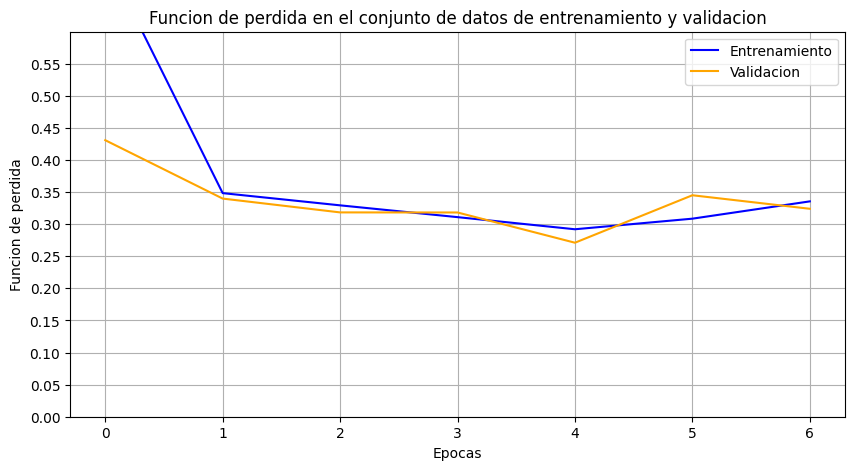

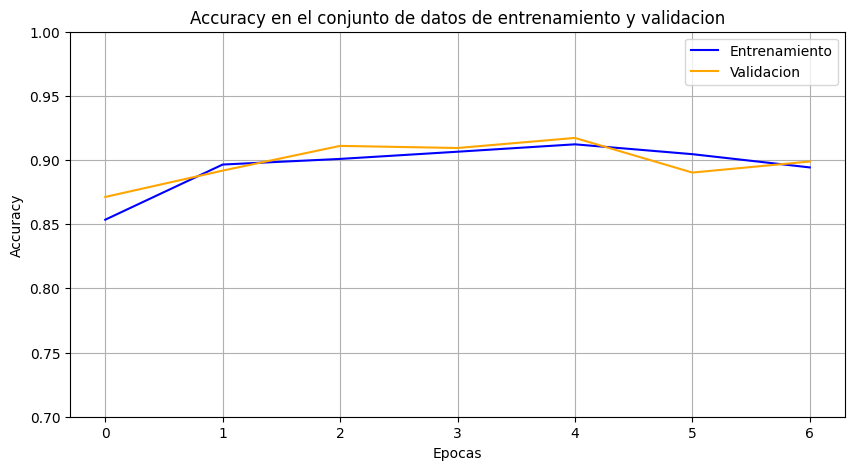

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

history =history_GRU.history

plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Entrenamiento', color='blue')
plt.plot(history['val_loss'], label='Validacion', color='orange')
plt.title('Funcion de perdida en el conjunto de datos de entrenamiento y validacion')
plt.xlabel('Epocas')
plt.ylabel('Funcion de perdida')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Entrenamiento', color='blue')
plt.plot(history['val_accuracy'], label='Validacion', color='orange')
plt.title('Accuracy en el conjunto de datos de entrenamiento y validacion')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y=0.7
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

In [ ]:
print(history['loss'])
print(history['val_loss'])
print(history['val_accuracy'])
print(history['accuracy'])

[0.7161116600036621, 0.3484630584716797, 0.3294185400009155, 0.3110435903072357, 0.292144775390625, 0.30865079164505005, 0.3356088101863861]
[0.4309481680393219, 0.3399597704410553, 0.3184240460395813, 0.3182912766933441, 0.2711823582649231, 0.3451458513736725, 0.3240734040737152]
[0.8712457418441772, 0.8917754292488098, 0.9110378623008728, 0.9093904495239258, 0.917247474193573, 0.8902547359466553, 0.8988721370697021]
[0.8535216450691223, 0.8965055346488953, 0.9008871912956238, 0.9065001010894775, 0.9122578501701355, 0.90458083152771, 0.8942603468894958]


### Comparativa de los 3 modelos

In [ ]:
history_CNN = {
    'loss': [0.507228672504425, 0.4193451702594757, 0.3723268508911133, 0.32292670011520386, 0.3000507056713104, 0.270298570394516, 0.24810069799423218, 0.22289857268333435, 0.21830973029136658, 0.18174704909324646, 0.1727839708328247, 0.16532360017299652, 0.14661313593387604, 0.1386595219373703, 0.13362154364585876, 0.12056571990251541],
    'val_loss': [0.4331760108470917, 0.3961290121078491, 0.3352775573730469, 0.3022574782371521, 0.2816530168056488, 0.27666816115379333, 0.2395983189344406, 0.23412461578845978, 0.23540878295898438, 0.19798414409160614, 0.1901058852672577, 0.2363535761833191, 0.1898985654115677, 0.17804072797298431, 0.18333597481250763, 0.18004193902015686],
    'val_accuracy': [0.790140688419342, 0.8271448612213135, 0.8600937724113464, 0.8804967403411865, 0.8879736661911011, 0.8919021487236023, 0.9072360992431641, 0.9083766341209412, 0.9091370105743408, 0.9234570860862732, 0.9287796020507812, 0.9095171689987183, 0.9310607314109802, 0.9323279857635498, 0.9303003549575806, 0.9334685206413269],
    'accuracy': [0.7729132771492004, 0.8001448512077332, 0.8340756893157959, 0.8680789470672607, 0.8794495463371277, 0.8927756547927856, 0.90284264087677, 0.9143218994140625, 0.9156617522239685, 0.9305087924003601, 0.9358319640159607, 0.9391635060310364, 0.9460437893867493, 0.9492304921150208, 0.9519101977348328, 0.9569799304008484]
}

history_LSTM = {
    'loss': [0.34309619665145874, 0.30100852251052856, 0.2730760872364044, 0.2448725551366806, 0.22818732261657715, 0.20779068768024445, 0.18998537957668304, 0.2190386950969696, 0.27778878808021545],
    'val_loss': [0.2964831292629242, 0.28422990441322327, 0.24904751777648926, 0.24243628978729248, 0.21767790615558624, 0.2671104669570923, 0.17862693965435028, 0.30556508898735046, 0.2755339741706848],
    'val_accuracy': [0.8886072635650635, 0.892662525177002, 0.9087567925453186, 0.9131922721862793, 0.9220631122589111, 0.9068559408187866, 0.9354961514472961, 0.8872132897377014, 0.8973513841629028],
    'accuracy': [0.8664131760597229, 0.8877784013748169, 0.8974470496177673, 0.9071156978607178, 0.9178345203399658, 0.9240630269050598, 0.9312692284584045, 0.9181966185569763, 0.9025529623031616]
}

history_GRU = {
    'loss': [0.7161116600036621, 0.3484630584716797, 0.3294185400009155, 0.3110435903072357, 0.292144775390625, 0.30865079164505005, 0.3356088101863861],
    'val_loss': [0.4309481680393219, 0.3399597704410553, 0.3184240460395813, 0.3182912766933441, 0.2711823582649231, 0.3451458513736725, 0.3240734040737152],
    'val_accuracy': [0.8712457418441772, 0.8917754292488098, 0.9110378623008728, 0.9093904495239258, 0.917247474193573, 0.8902547359466553, 0.8988721370697021],
    'accuracy': [0.8535216450691223, 0.8965055346488953, 0.9008871912956238, 0.9065001010894775, 0.9122578501701355, 0.90458083152771, 0.8942603468894958]
}


In [ ]:
history_CNN['val_accuracy'][13]

0.9323279857635498

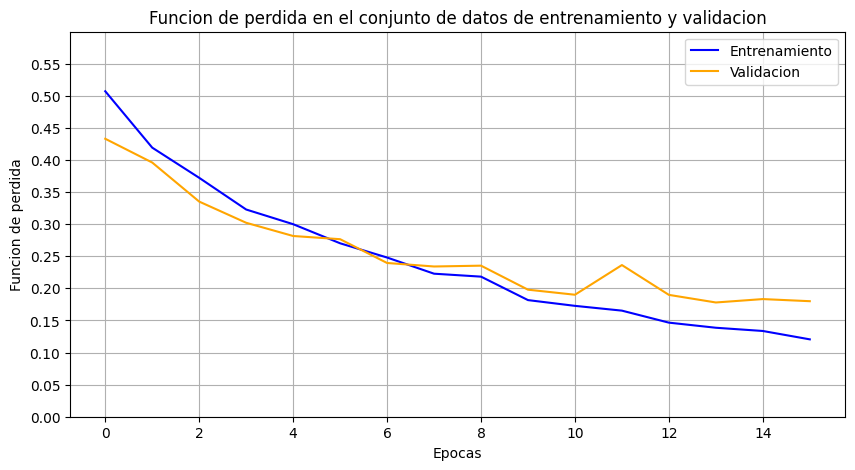

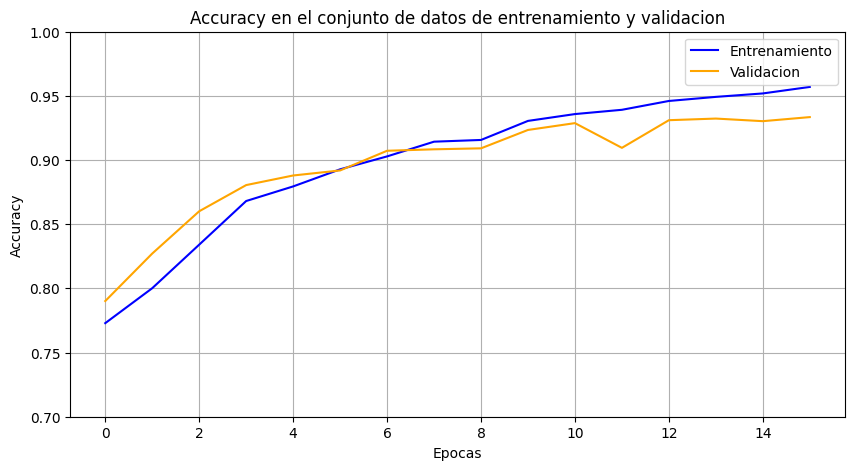

In [ ]:
pintar_metricas(history_CNN)

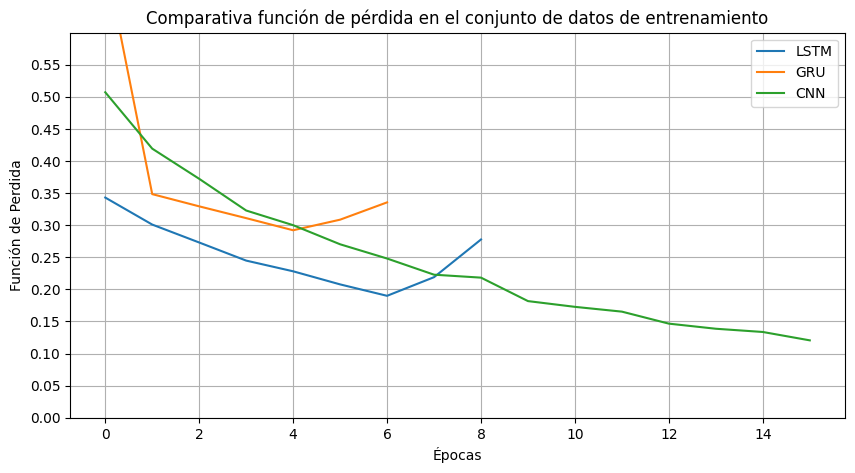

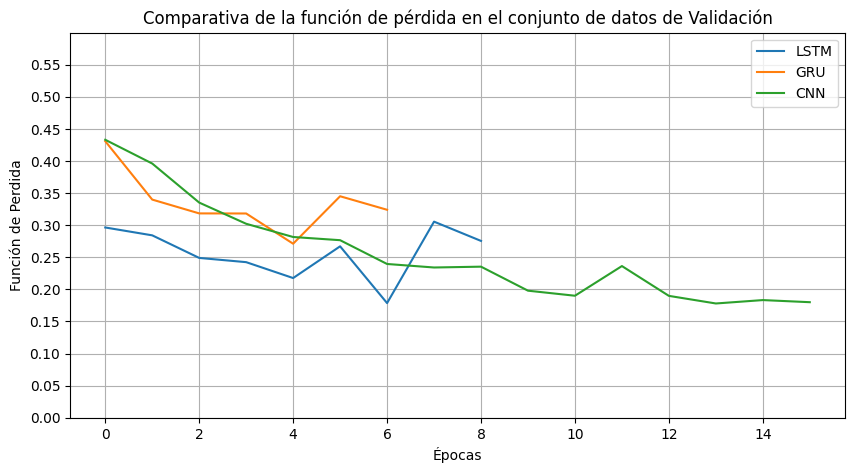

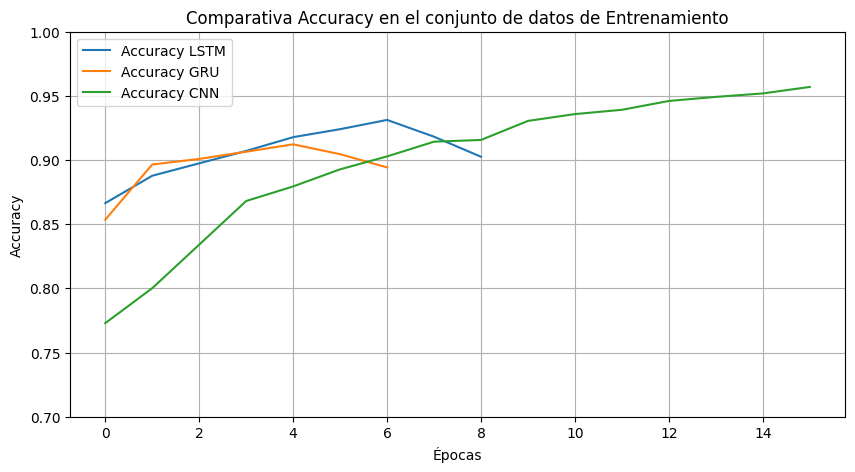

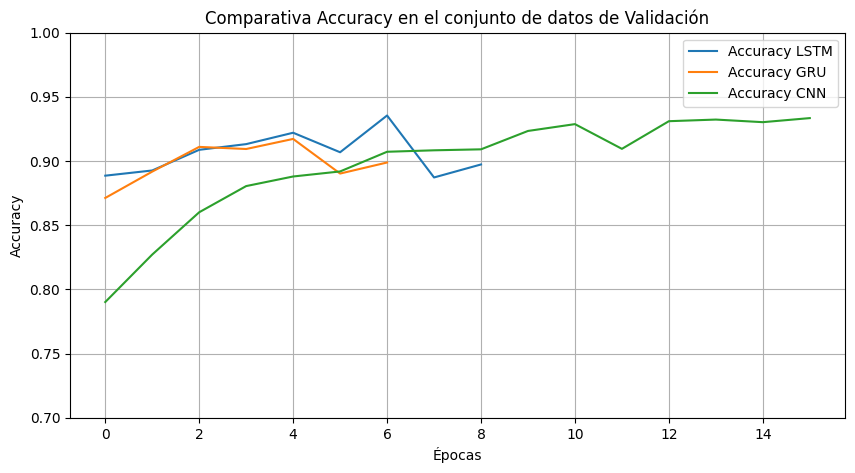

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# history_LSTM =history_LSTM.history
# history_GRU = history_GRU.history
# history_CNN = history_CNN.history

plt.figure(figsize=(10, 5))
plt.plot(history_LSTM['loss'], label='LSTM')
plt.plot(history_GRU['loss'], label='GRU')
plt.plot(history_CNN['loss'], label='CNN')
plt.title('Comparativa función de pérdida en el conjunto de datos de entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Función de Perdida')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_LSTM['val_loss'], label='LSTM')
plt.plot(history_GRU['val_loss'], label='GRU')
plt.plot(history_CNN['val_loss'], label='CNN')
plt.title('Comparativa de la función de pérdida en el conjunto de datos de Validación')
plt.xlabel('Épocas')
plt.ylabel('Función de Perdida')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_LSTM['accuracy'], label='Accuracy LSTM')
plt.plot(history_GRU['accuracy'], label='Accuracy GRU')
plt.plot(history_CNN['accuracy'], label='Accuracy CNN')
plt.title('Comparativa Accuracy en el conjunto de datos de Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y=0.7
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_LSTM['val_accuracy'], label='Accuracy LSTM')
plt.plot(history_GRU['val_accuracy'], label='Accuracy GRU')
plt.plot(history_CNN['val_accuracy'], label='Accuracy CNN')
plt.title('Comparativa Accuracy en el conjunto de datos de Validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y=0.7
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()


Segun estas gráficas el mejor modelo es CNN.

### Entrenamiento del modelo con todos los datos


In [9]:
df_union = pd.concat([df_train, df_valid], ignore_index=True)

In [10]:
X, y = filtrado_datos_variable(df_union)

In [11]:
X = pad_sequences(X, maxlen=max_length, padding='post', dtype='float32')
X_p = np.expand_dims(X, -1)

In [12]:
file_test = 'df_test.csv'
path_test = os.path.join(path_actual, subdirectorio, file_test)
df_test = pd.read_csv(path_test, index_col=None)

In [13]:
X_test, y_test = filtrado_datos_variable(df_test)
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', dtype='float32')
X_test_p = np.expand_dims(X_test, -1)

In [14]:
# Funcion para crear el modelo
def create_model_CNN(input_shape):
    model = Sequential()

    # Capa de máscara para ignorar los valores de padding
    # model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # Se eliminan las especificaciones de input_shape para permitir cualquier longitud de entrada
    model.add(Conv1D(filters=128, kernel_size=10, padding='valid', activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=8, padding='valid', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [15]:
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Conv1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout
from keras.regularizers import l1_l2
from keras.optimizers import Adam
tf.random.set_seed(42)

# Asumiendo que X_train y X_valid ya están disponibles como listas de arrays de numpy con dimensiones (samples, features)
# No es necesario reorganizar los datos ya que no especificamos una longitud fija

# Creamos el modelo
model_CNN = create_model_CNN(input_shape=X_p.shape[1:])

# Definimos callbacks para los entrenamientos
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=0, min_lr=0.00001)

# Entrenamos el modelo
history_CNN_final = model_CNN.fit(X_p, y, epochs=50, batch_size=32, callbacks=[early_stop, reduce_lr])

# Evaluamos el modelo
loss_test, accuracy_test = model_CNN.evaluate(X_test_p, y_test)
print("Loss:", loss_test)
print("Accuracy:", accuracy_test)

Epoch 1/50
1110/1110 [==============================] - 93s 77ms/step - loss: 0.4839 - accuracy: 0.7771 - lr: 0.0010
Epoch 2/50
1110/1110 [==============================] - 89s 80ms/step - loss: 0.3968 - accuracy: 0.8201 - lr: 0.0010
Epoch 3/50
1110/1110 [==============================] - 89s 80ms/step - loss: 0.3264 - accuracy: 0.8668 - lr: 0.0010
Epoch 4/50
1110/1110 [==============================] - 89s 80ms/step - loss: 0.2738 - accuracy: 0.8925 - lr: 0.0010
Epoch 5/50
1110/1110 [==============================] - 88s 80ms/step - loss: 0.2480 - accuracy: 0.9042 - lr: 0.0010
Epoch 6/50
1110/1110 [==============================] - 88s 80ms/step - loss: 0.2247 - accuracy: 0.9132 - lr: 0.0010
Epoch 7/50
1110/1110 [==============================] - 88s 79ms/step - loss: 0.2129 - accuracy: 0.9195 - lr: 0.0010
Epoch 8/50
1110/1110 [==============================] - 88s 79ms/step - loss: 0.1998 - accuracy: 0.9238 - lr: 0.0010
Epoch 9/50
1110/1110 [==============================] - 88s 79ms

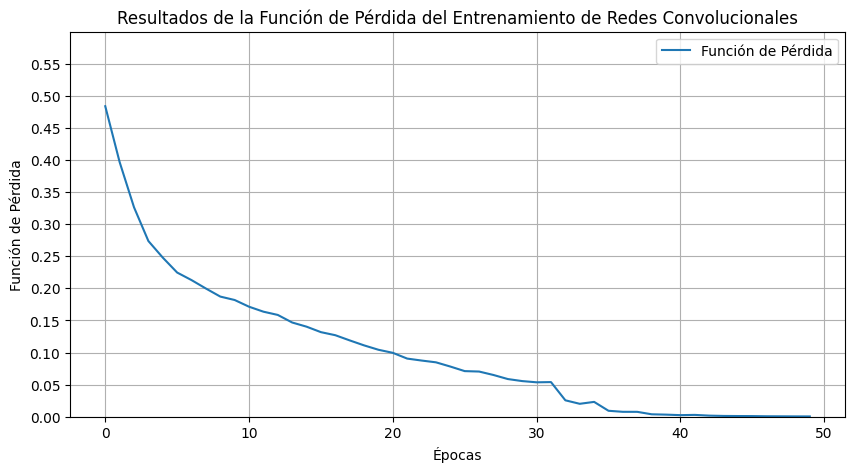

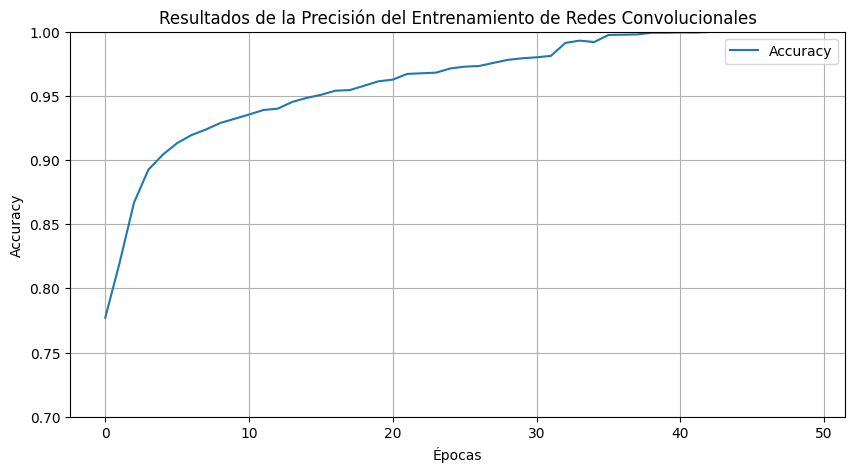

In [20]:
import matplotlib.pyplot as plt
# Acceder a los datos del entrenamiento
history = history_CNN_final.history

# Graficar la función de pérdida
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Función de Pérdida')
plt.title('Resultados de la Función de Pérdida del Entrenamiento de Redes Convolucionales')
plt.xlabel('Épocas')
plt.ylabel('Función de Pérdida')
plt.legend()
plt.grid(True)
min_y = 0
max_y = 0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

# Graficar la precisión (accuracy)
plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Accuracy')
plt.title('Resultados de la Precisión del Entrenamiento de Redes Convolucionales')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y = 0.7
max_y = 1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

### Resultados de los disintos accuracy en bajas, medias o altas energías

In [21]:
def filtrado_datos_variable_energia(df):
    kaones = []
    labels = []
    valores_trueE = []

    df_sorted = df.sort_values(by=['eventID', 'hitTime'], ascending=[True, False])

    for eventID, grupo in df_sorted.groupby('eventID'):
        pdgCodes = grupo['PDGcode'].unique()

        for pdgCode in pdgCodes:
            grupo_filtrado = grupo[grupo['PDGcode'] == pdgCode]

            #Obtener el valor de 'trueE' para el evento actual
            trueE_value = grupo_filtrado['trueE'].iloc[0]

            # Almacenar el valor de 'trueE' para evento Actual
            valores_trueE.append(trueE_value)

            # Extraer directamente los valores
            hitX_values = grupo_filtrado['hitX'].values
            hitY_values = grupo_filtrado['hitY'].values
            hitZ_values = grupo_filtrado['hitZ'].values
            hitInteg_values = grupo_filtrado['hitInteg'].values

            # Concatenar los valores directamente sin padding
            hit_values_reorganized = np.concatenate([[trueE_value], hitX_values, hitY_values, hitZ_values, hitInteg_values])

            kaones.append(hit_values_reorganized)

            # Modificar las etiquetas de 211 a 0 y de 321 a 1
            if pdgCode == 211:
                labels.append(0)
            elif pdgCode == 321:
                labels.append(1)

    return kaones, np.array(labels), np.array(list(valores_trueE))

In [22]:
X_train_energia, y_train_energia, trueE_train = filtrado_datos_variable_energia(df_train)
X_valid_energia, y_valid_energia, trueE_valid = filtrado_datos_variable_energia(df_valid)

In [23]:
def dividir_baja_media_alta(trueE):
  trueE_ordenado = np.sort(trueE)
  n_baja_media = len(trueE) // 3
  n_media_alta = (len(trueE) // 3) + n_baja_media
  baja_media = trueE_ordenado[n_baja_media]
  media_alta = trueE_ordenado[n_media_alta]

  return baja_media, media_alta

In [24]:
baja_media, media_alta = dividir_baja_media_alta(trueE_train)

print('Valor que corta en la zona baja/media:', baja_media)
print('Valor que corta en la zona media/alta:', media_alta)

Valor que corta en la zona baja/media: 0.42793
Valor que corta en la zona media/alta: 0.559643


In [25]:
def calcular_distintos_accuracy(X, y, y_predicciones, valor_baja_media, valor_media_alta):
    total_predicciones_bajas = np.sum(X[:, 0] < valor_baja_media)
    total_predicciones_medias = np.sum((X[:, 0] >= valor_baja_media) & (X[:, 0] < valor_media_alta))
    total_predicciones_altas = np.sum(X[:, 0] >= valor_media_alta)

    aciertos_bajas = np.sum((X[:, 0] < valor_baja_media) & (y == y_predicciones))
    error_bajas = total_predicciones_bajas - aciertos_bajas

    aciertos_medias = np.sum((X[:, 0] >= valor_baja_media) & (X[:, 0] < valor_media_alta) & (y == y_predicciones))
    error_medias = total_predicciones_medias - aciertos_medias

    aciertos_altas = np.sum((X[:, 0] >= valor_media_alta) & (y == y_predicciones))
    errores_altas = total_predicciones_altas - aciertos_altas

    accuracy_baja = aciertos_bajas / total_predicciones_bajas if total_predicciones_bajas > 0 else np.nan
    accuracy_media = aciertos_medias / total_predicciones_medias if total_predicciones_medias > 0 else np.nan
    accuracy_alta = aciertos_altas / total_predicciones_altas if total_predicciones_altas > 0 else np.nan

    return accuracy_baja, accuracy_media, accuracy_alta

In [27]:
del model_CNN

In [28]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_CNN = create_model_CNN(input_shape=X_train_p.shape[1:])


early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0, min_lr=0.00001)

# Entrenamos el modelo
history_CNN = model_CNN.fit(X_train_p, y_train, epochs=50, batch_size=32, validation_data=(X_valid_p, y_valid), callbacks=[early_stop, reduce_lr])

Epoch 1/50
863/863 [==============================] - 84s 95ms/step - loss: 0.5014 - accuracy: 0.7739 - val_loss: 0.4346 - val_accuracy: 0.7918 - lr: 0.0010
Epoch 2/50
863/863 [==============================] - 76s 88ms/step - loss: 0.4038 - accuracy: 0.8152 - val_loss: 0.3533 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 3/50
863/863 [==============================] - 76s 88ms/step - loss: 0.3356 - accuracy: 0.8614 - val_loss: 0.3020 - val_accuracy: 0.8806 - lr: 0.0010
Epoch 4/50
863/863 [==============================] - 76s 88ms/step - loss: 0.2898 - accuracy: 0.8868 - val_loss: 0.2764 - val_accuracy: 0.8928 - lr: 0.0010
Epoch 5/50
863/863 [==============================] - 75s 87ms/step - loss: 0.2658 - accuracy: 0.8960 - val_loss: 0.2745 - val_accuracy: 0.8943 - lr: 0.0010
Epoch 6/50
863/863 [==============================] - 79s 91ms/step - loss: 0.2429 - accuracy: 0.9054 - val_loss: 0.2639 - val_accuracy: 0.9003 - lr: 0.0010
Epoch 7/50
863/863 [==============================] - 79s 

In [ ]:
from sklearn.metrics import accuracy_score

# Realizar predicciones
predicciones_train = model_CNN.predict(X_train_p)

# Convertir las predicciones en etiquetas de clase
clases_predecidas_train = (predicciones_train > 0.5).astype(int)

acc_bajas_train, acc_media_train, acc_alta_train = calcular_distintos_accuracy(X_train_p, y_train_energia, clases_predecidas_train, baja_media, media_alta)
accuracy_train = accuracy_score(y_train_energia, clases_predecidas_train)

print('Accuracy para train:', accuracy_train)
print('Accuracy para energías bajas:', acc_bajas_train)
print('Accuracy para energías medias:', acc_media_train)
print('Accuracy para energías altas:', acc_alta_train)

In [ ]:
predicciones_valid = model_CNN.predict(X_valid_p)
clases_predecidas_valid = (predicciones_valid > 0.5).astype(int)

acc_bajas_valid, acc_media_valid, acc_alta_valid = calcular_distintos_accuracy(X_valid_p, y_valid_energia, clases_predecidas_valid, baja_media, media_alta)
accuracy_valid = accuracy_score(y_valid_energia, clases_predecidas_valid)

print('Accuracy para valid:', accuracy_valid)
print('Accuracy para energías bajas:', acc_bajas_valid)
print('Accuracy para energías medias:', acc_media_valid)
print('Accuracy para energías altas:', acc_alta_valid)

In [ ]:
df_union = pd.concat([df_train, df_valid], ignore_index=True)
X, y = filtrado_datos_variable(df_union)

X = pad_sequences(X, maxlen=max_length, padding='post', dtype='float32')
X_p = np.expand_dims(X, -1)

X_energia, y_energía, trueE_todos = filtrado_datos_variable(df_union)

model_CNN = create_model_CNN(input_shape=X_p.shape[1:])
history_CNN = model_CNN.fit(X_p, y, epochs=50, batch_size=32, callbacks=[early_stop, reduce_lr])

In [ ]:
X_test, y_test = filtrado_datos_variable(df_test)
X_test_energia, y_test_energia, trueE_test = filtrado_datos_variable_energia(df_test)

X_test = pad_sequences(X_test, maxlen=max_length, padding='post', dtype='float32')
X_test_p = np.expand_dims(X_test, -1)


# Realizar predicciones
predicciones_test = model_CNN.predict(X_test_p)

# Convertir las predicciones en etiquetas de clase
clases_predecidas_test = (predicciones_test > 0.5).astype(int)

acc_bajas_test, acc_media_test, acc_alta_test = calcular_distintos_accuracy(X_test_p, y_test_energia, clases_predecidas_test, baja_media, media_alta)
accuracy_test = accuracy_score(y_test_energia, clases_predichas_test)

print('Accuracy para test:', accuracy_test)
print('Accuracy para energías bajas:', acc_bajas_test)
print('Accuracy para energías medias:', acc_media_test)
print('Accuracy para energías altas:', acc_alta_test)

In [ ]:
# Crear datos para el histograma
labels = ['General', 'Baja Energía', 'Media Energía', 'Alta Energía']
train_data = [accuracy_train, acc_bajas_train, acc_media_train, acc_alta_train]
valid_data = [accuracy_valid, acc_bajas_valid, acc_media_valid, acc_alta_valid]
test_data = [accuracy_test, acc_bajas_test, acc_media_test, acc_alta_test]

x = range(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, train_data, width, label='Train')
rects2 = ax.bar([p + width for p in x], valid_data, width, label='Validation')
rects3 = ax.bar([p + width * 2 for p in x], test_data, width, label='Test')

# Añadir algunas etiquetas, título y etiquetas de ejes personalizadas
ax.set_xlabel('Tipo de Precisión')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy por tipo de energía y conjunto de datos')
ax.set_xticks([p + width for p in x])
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



fig.tight_layout()

plt.show()